In [ ]:
# ============================================================================
# DIABETES PREDICTION MODEL - GOOGLE COLAB VERSION
# Using Best ML Models: XGBoost, CatBoost, Random Forest + Ensemble
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Install required packages for Google Colab
!pip install xgboost catboost lightgbm imbalanced-learn

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

# For Google Colab
%matplotlib inline

print("🩺 DIABETES PREDICTION MODEL - GOOGLE COLAB")
print("="*60)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00
🩺 DIABETES PREDICTION MODEL - GOOGLE COLAB


In [ ]:
# Upload dataset to Google Colab
from google.colab import files
print("📁 Please upload your diabetes_prediction_dataset.csv file:")
uploaded = files.upload()

# Load the diabetes dataset
df = pd.read_csv('/content/drive/My Drive/diabetes_prediction_dataset.csv')
print("✅ Diabetes dataset loaded successfully!")

print(f"Dataset shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nDataset info:")
print(df.info())


📁 Please upload your diabetes_prediction_dataset.csv file:


Saving diabetes_prediction_dataset.csv to diabetes_prediction_dataset.csv
✅ Diabetes dataset loaded successfully!
Dataset shape: (100000, 9)

First 5 rows:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   

In [ ]:
# ============================================================================
# DATA EXPLORATION AND ANALYSIS
# ============================================================================

print("\n📊 DIABETES DATASET ANALYSIS")
print("="*50)
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())

# Check target distribution
print(f"\nDiabetes distribution:")
print(df['diabetes'].value_counts())
print(f"Percentage with Diabetes: {(df['diabetes'].sum() / len(df) * 100):.1f}%")

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print(f"\nDataset statistics:")
print(df.describe())

# Check unique values for categorical features
categorical_features = ['gender', 'hypertension', 'heart_disease', 'smoking_history']
for feature in categorical_features:
    if feature in df.columns:
        print(f"\n{feature} unique values:")
        print(df[feature].value_counts())



📊 DIABETES DATASET ANALYSIS
Dataset shape: (100000, 9)

Column names:
['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

Diabetes distribution:
diabetes
0    91500
1     8500
Name: count, dtype: int64
Percentage with Diabetes: 8.5%

Missing values:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Dataset statistics:
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%   

In [ ]:
# ============================================================================
# DATA PREPROCESSING
# ============================================================================

def preprocess_diabetes_data(df):
    """Preprocess diabetes dataset"""
    df_processed = df.copy()

    # Encode categorical variables
    label_encoders = {}

    # Handle gender
    if 'gender' in df_processed.columns:
        le_gender = LabelEncoder()
        df_processed['gender'] = le_gender.fit_transform(df_processed['gender'])
        label_encoders['gender'] = le_gender
        print(f"Gender encoded: {dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_)))}")

    # Handle smoking_history
    if 'smoking_history' in df_processed.columns:
        le_smoking = LabelEncoder()
        df_processed['smoking_history'] = le_smoking.fit_transform(df_processed['smoking_history'])
        label_encoders['smoking_history'] = le_smoking
        print(f"Smoking history encoded: {dict(zip(le_smoking.classes_, le_smoking.transform(le_smoking.classes_)))}")

    # Binary features (hypertension, heart_disease, diabetes) should already be 0/1
    # But ensure they're numeric
    binary_features = ['hypertension', 'heart_disease', 'diabetes']
    for feature in binary_features:
        if feature in df_processed.columns:
            df_processed[feature] = pd.to_numeric(df_processed[feature], errors='coerce').fillna(0).astype(int)

    print(f"✅ Data preprocessing complete!")
    print(f"Final dataset shape: {df_processed.shape}")

    return df_processed, label_encoders

# Preprocess the data
df_processed, encoders = preprocess_diabetes_data(df)

# Define features and target
feature_columns = [col for col in df_processed.columns if col != 'diabetes']
X = df_processed[feature_columns]
y = df_processed['diabetes']

print(f"\nFeature columns: {feature_columns}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")


Gender encoded: {'Female': np.int64(0), 'Male': np.int64(1), 'Other': np.int64(2)}
Smoking history encoded: {'No Info': np.int64(0), 'current': np.int64(1), 'ever': np.int64(2), 'former': np.int64(3), 'never': np.int64(4), 'not current': np.int64(5)}
✅ Data preprocessing complete!
Final dataset shape: (100000, 9)

Feature columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Feature matrix shape: (100000, 8)
Target distribution: {0: 91500, 1: 8500}


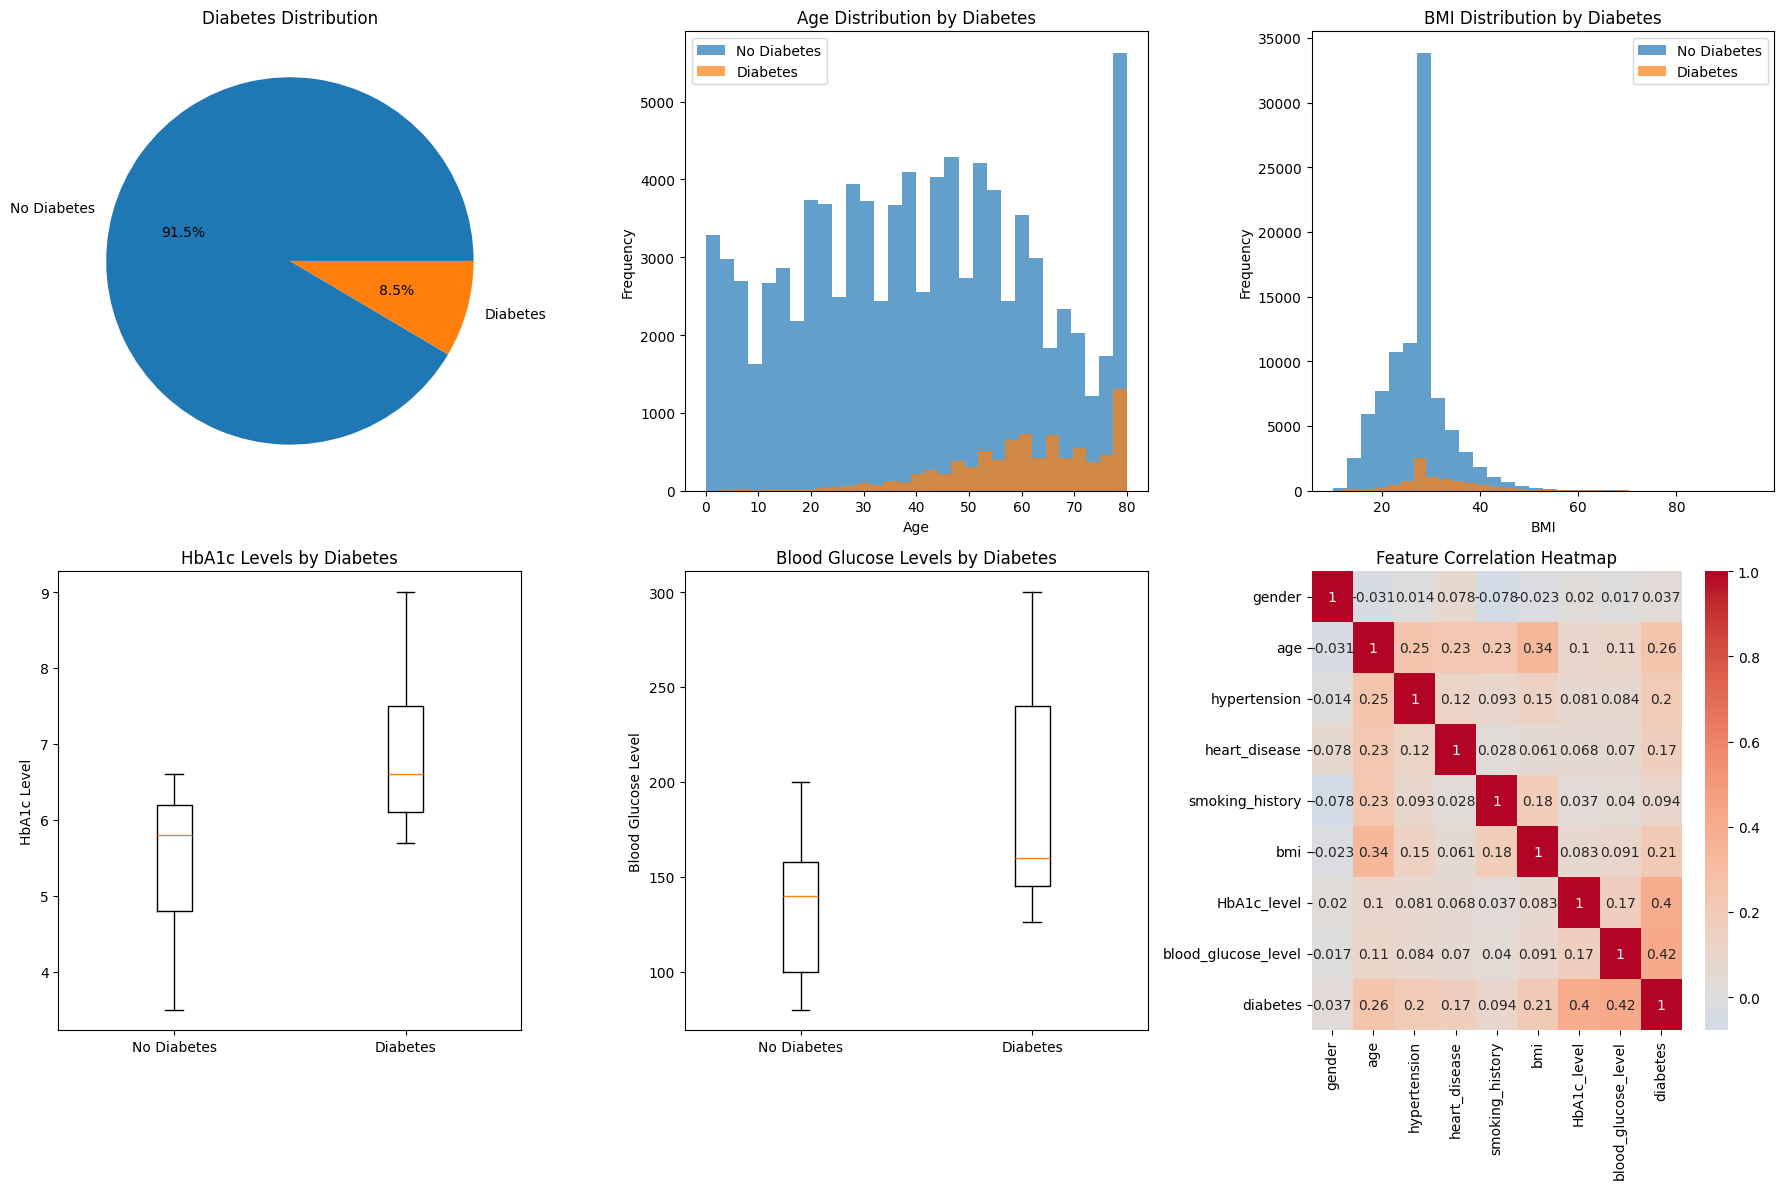

In [ ]:
# ============================================================================
# DATA VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Target distribution
axes[0,0].pie(y.value_counts().values, labels=['No Diabetes', 'Diabetes'], autopct='%1.1f%%')
axes[0,0].set_title('Diabetes Distribution')

# Plot 2: Age distribution by diabetes
axes[0,1].hist(df[df['diabetes']==0]['age'], alpha=0.7, label='No Diabetes', bins=30)
axes[0,1].hist(df[df['diabetes']==1]['age'], alpha=0.7, label='Diabetes', bins=30)
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Age Distribution by Diabetes')
axes[0,1].legend()

# Plot 3: BMI distribution by diabetes
axes[0,2].hist(df[df['diabetes']==0]['bmi'], alpha=0.7, label='No Diabetes', bins=30)
axes[0,2].hist(df[df['diabetes']==1]['bmi'], alpha=0.7, label='Diabetes', bins=30)
axes[0,2].set_xlabel('BMI')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('BMI Distribution by Diabetes')
axes[0,2].legend()

# Plot 4: HbA1c levels by diabetes
axes[1,0].boxplot([df[df['diabetes']==0]['HbA1c_level'], df[df['diabetes']==1]['HbA1c_level']],
                  labels=['No Diabetes', 'Diabetes'])
axes[1,0].set_ylabel('HbA1c Level')
axes[1,0].set_title('HbA1c Levels by Diabetes')

# Plot 5: Blood glucose levels by diabetes
axes[1,1].boxplot([df[df['diabetes']==0]['blood_glucose_level'], df[df['diabetes']==1]['blood_glucose_level']],
                  labels=['No Diabetes', 'Diabetes'])
axes[1,1].set_ylabel('Blood Glucose Level')
axes[1,1].set_title('Blood Glucose Levels by Diabetes')

# Plot 6: Correlation heatmap
corr_matrix = df_processed.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
axes[1,2].set_title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# DATA SPLITTING AND SCALING
# ============================================================================

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale numerical features
scaler = StandardScaler()
numerical_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print(f"✅ Feature scaling complete for: {numerical_features}")

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set: {X_train.shape[0]} samples")
print(f"After SMOTE: {X_train_smote.shape[0]} samples")
print(f"Class distribution after SMOTE: {pd.Series(y_train_smote).value_counts().to_dict()}")


Training set size: 80000
Test set size: 20000
✅ Feature scaling complete for: ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Original training set: 80000 samples
After SMOTE: 146400 samples
Class distribution after SMOTE: {1: 73200, 0: 73200}


In [ ]:
# ============================================================================
# MODEL TRAINING - BEST PERFORMING MODELS
# ============================================================================

print("\n🩺 TRAINING DIABETES PREDICTION MODELS")
print("="*60)

# Model 1: XGBoost (Research shows 97.4% accuracy)
print("1️⃣ Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_smote, y_train_smote)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_prob)

print(f"✅ XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"✅ XGBoost AUC: {xgb_auc:.4f}")

# Model 2: CatBoost (Research shows 95.7% accuracy)
print("\n2️⃣ Training CatBoost...")
cat_model = cb.CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=False
)

cat_model.fit(X_train_smote, y_train_smote)
cat_pred = cat_model.predict(X_test_scaled)
cat_prob = cat_model.predict_proba(X_test_scaled)[:, 1]
cat_accuracy = accuracy_score(y_test, cat_pred)
cat_auc = roc_auc_score(y_test, cat_prob)

print(f"✅ CatBoost Accuracy: {cat_accuracy:.4f}")
print(f"✅ CatBoost AUC: {cat_auc:.4f}")

# Model 3: LightGBM
print("\n3️⃣ Training LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbose=-1
)

lgb_model.fit(X_train_smote, y_train_smote)
lgb_pred = lgb_model.predict(X_test_scaled)
lgb_prob = lgb_model.predict_proba(X_test_scaled)[:, 1]
lgb_accuracy = accuracy_score(y_test, lgb_pred)
lgb_auc = roc_auc_score(y_test, lgb_prob)

print(f"✅ LightGBM Accuracy: {lgb_accuracy:.4f}")
print(f"✅ LightGBM AUC: {lgb_auc:.4f}")

# Model 4: Random Forest (Research shows good performance)
print("\n4️⃣ Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_smote, y_train_smote)
rf_pred = rf_model.predict(X_test_scaled)
rf_prob = rf_model.predict_proba(X_test_scaled)[:, 1]
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_prob)

print(f"✅ Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"✅ Random Forest AUC: {rf_auc:.4f}")



🩺 TRAINING DIABETES PREDICTION MODELS
1️⃣ Training XGBoost...
✅ XGBoost Accuracy: 0.9696
✅ XGBoost AUC: 0.9778

2️⃣ Training CatBoost...
✅ CatBoost Accuracy: 0.9714
✅ CatBoost AUC: 0.9790

3️⃣ Training LightGBM...
✅ LightGBM Accuracy: 0.9704
✅ LightGBM AUC: 0.9783

4️⃣ Training Random Forest...
✅ Random Forest Accuracy: 0.9345
✅ Random Forest AUC: 0.9745


In [ ]:
# ============================================================================
# HYPERPARAMETER TUNING FOR BEST MODELS
# ============================================================================

print("\n🔧 HYPERPARAMETER TUNING")
print("="*40)

# XGBoost Hyperparameter Tuning
print("Tuning XGBoost...")
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_random_search = RandomizedSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    xgb_param_grid,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

xgb_random_search.fit(X_train_smote, y_train_smote)
best_xgb = xgb_random_search.best_estimator_

# CatBoost Hyperparameter Tuning
print("Tuning CatBoost...")
cat_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

cat_random_search = RandomizedSearchCV(
    cb.CatBoostClassifier(random_state=42, verbose=False),
    cat_param_grid,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

cat_random_search.fit(X_train_smote, y_train_smote)
best_cat = cat_random_search.best_estimator_

print(f"✅ Best XGBoost params: {xgb_random_search.best_params_}")
print(f"✅ Best CatBoost params: {cat_random_search.best_params_}")



🔧 HYPERPARAMETER TUNING
Tuning XGBoost...
Tuning CatBoost...
✅ Best XGBoost params: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1}
✅ Best CatBoost params: {'learning_rate': 0.2, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 8}


In [ ]:
# ============================================================================
# MODEL EVALUATION AND COMPARISON
# ============================================================================

# Evaluate tuned models
best_xgb_pred = best_xgb.predict(X_test_scaled)
best_xgb_prob = best_xgb.predict_proba(X_test_scaled)[:, 1]
best_xgb_accuracy = accuracy_score(y_test, best_xgb_pred)
best_xgb_auc = roc_auc_score(y_test, best_xgb_prob)

best_cat_pred = best_cat.predict(X_test_scaled)
best_cat_prob = best_cat.predict_proba(X_test_scaled)[:, 1]
best_cat_accuracy = accuracy_score(y_test, best_cat_pred)
best_cat_auc = roc_auc_score(y_test, best_cat_prob)

# Create ensemble model
ensemble_prob = (best_xgb_prob + best_cat_prob + lgb_prob + rf_prob) / 4
ensemble_pred = (ensemble_prob > 0.5).astype(int)
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
ensemble_auc = roc_auc_score(y_test, ensemble_prob)

# Model comparison
models = {
    'XGBoost (Tuned)': (best_xgb, best_xgb_prob, best_xgb_accuracy, best_xgb_auc),
    'CatBoost (Tuned)': (best_cat, best_cat_prob, best_cat_accuracy, best_cat_auc),
    'LightGBM': (lgb_model, lgb_prob, lgb_accuracy, lgb_auc),
    'Random Forest': (rf_model, rf_prob, rf_accuracy, rf_auc),
    'Ensemble': (None, ensemble_prob, ensemble_accuracy, ensemble_auc)
}

# Select best model
best_model_name = max(models.keys(), key=lambda x: models[x][3])
best_model = models[best_model_name][0]
best_prob = models[best_model_name][1]
best_accuracy = models[best_model_name][2]
best_auc = models[best_model_name][3]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"🎯 Best Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"🎯 Best AUC Score: {best_auc:.4f}")

# Detailed classification report
if best_model_name != 'Ensemble':
    best_pred = best_model.predict(X_test_scaled)
else:
    best_pred = ensemble_pred

print(f"\n📊 CLASSIFICATION REPORT ({best_model_name}):")
print(classification_report(y_test, best_pred))



🏆 BEST MODEL: LightGBM
🎯 Best Accuracy: 0.9704 (97.04%)
🎯 Best AUC Score: 0.9783

📊 CLASSIFICATION REPORT (LightGBM):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.92      0.71      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.95      0.85      0.89     20000
weighted avg       0.97      0.97      0.97     20000



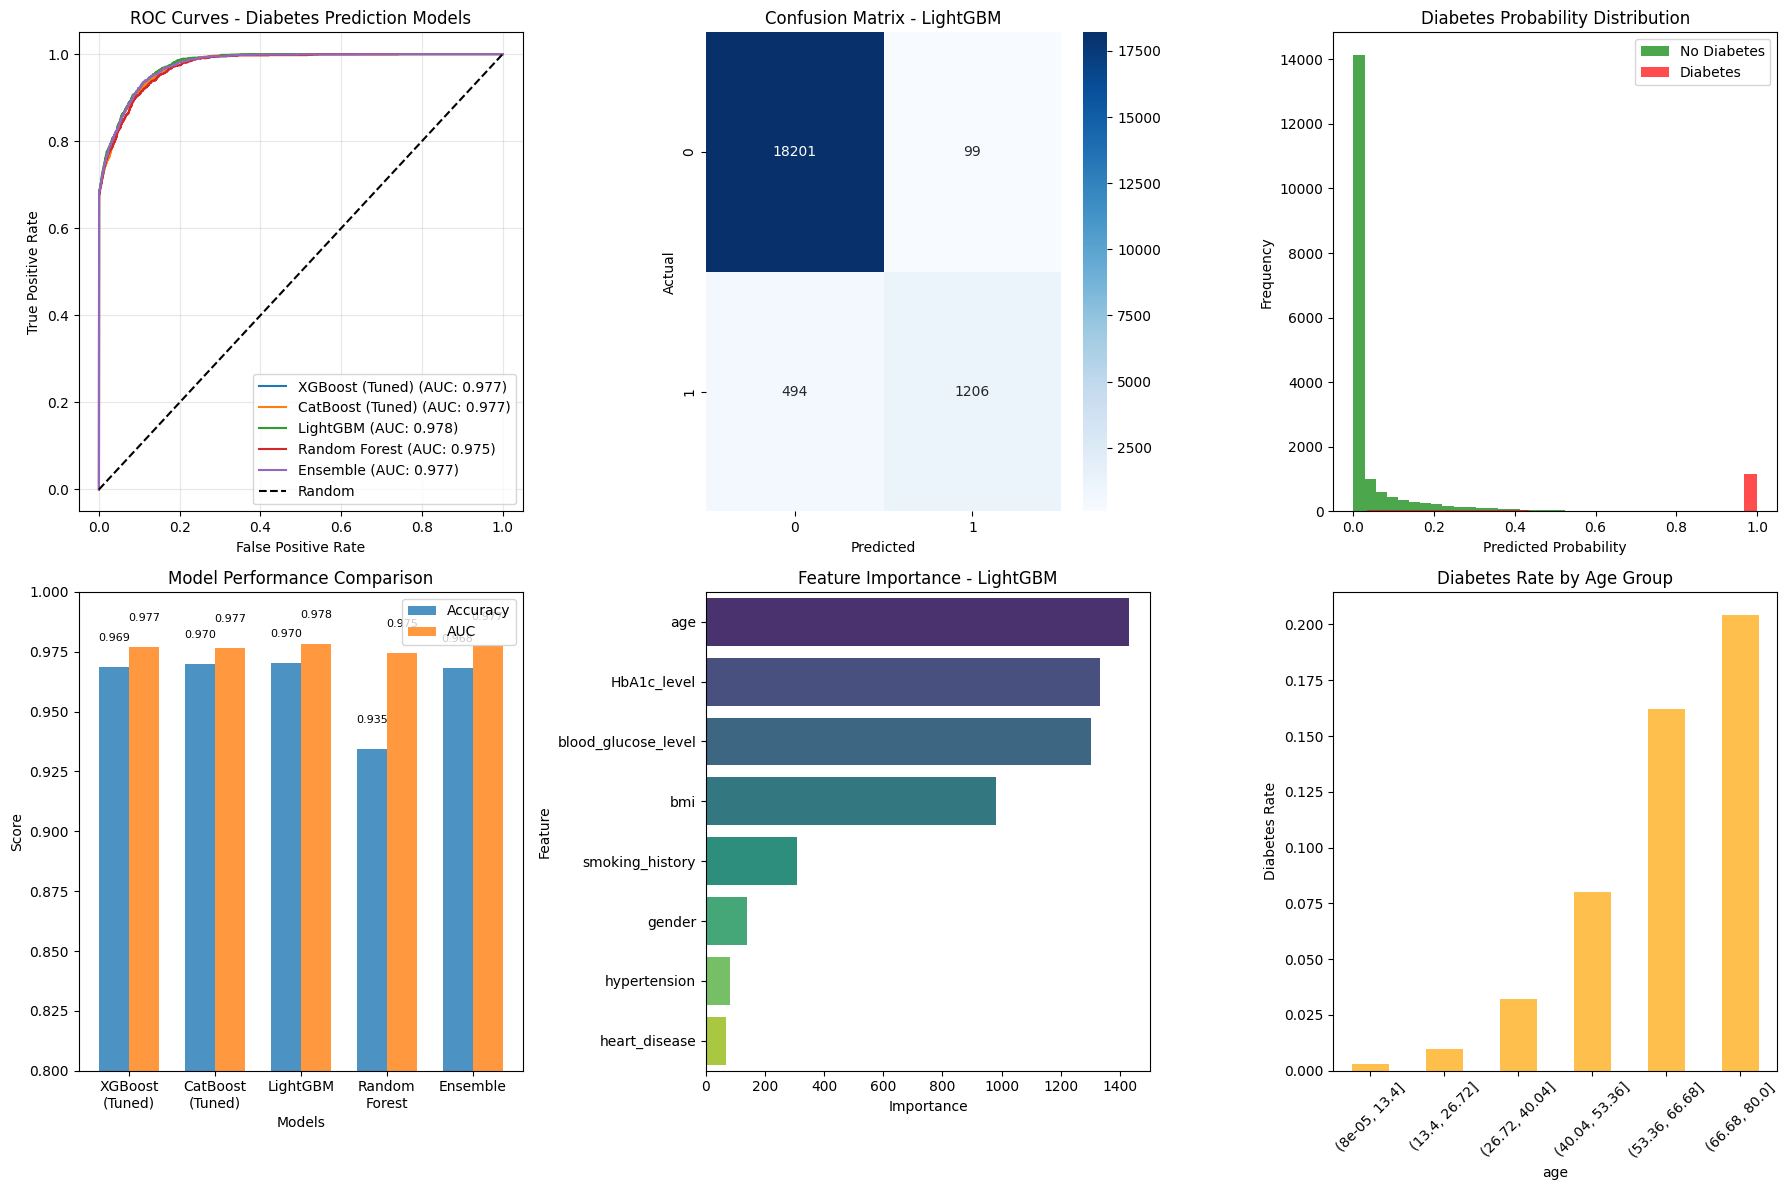

In [ ]:
# ============================================================================
# COMPREHENSIVE VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: ROC Curves
axes[0,0].set_title('ROC Curves - Diabetes Prediction Models')
for name, (model, prob, acc, auc) in models.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    axes[0,0].plot(fpr, tpr, label=f"{name} (AUC: {auc:.3f})")
axes[0,0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Confusion Matrix
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title(f'Confusion Matrix - {best_model_name}')
axes[0,1].set_ylabel('Actual')
axes[0,1].set_xlabel('Predicted')

# Plot 3: Probability Distribution
axes[0,2].hist(best_prob[y_test == 0], alpha=0.7, label='No Diabetes', bins=30, color='green')
axes[0,2].hist(best_prob[y_test == 1], alpha=0.7, label='Diabetes', bins=30, color='red')
axes[0,2].set_xlabel('Predicted Probability')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Diabetes Probability Distribution')
axes[0,2].legend()

# Plot 4: Model Performance Comparison
model_names = list(models.keys())
accuracies = [models[name][2] for name in model_names]
aucs = [models[name][3] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = axes[1,0].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
bars2 = axes[1,0].bar(x + width/2, aucs, width, label='AUC', alpha=0.8)

axes[1,0].set_xlabel('Models')
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Model Performance Comparison')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels([name.replace(' ', '\n') for name in model_names])
axes[1,0].legend()
axes[1,0].set_ylim(0.8, 1.0)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 5: Feature Importance (for tree-based models)
if best_model_name != 'Ensemble' and hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    sns.barplot(data=importance_df, x='Importance', y='Feature', ax=axes[1,1], palette='viridis')
    axes[1,1].set_title(f'Feature Importance - {best_model_name}')
else:
    axes[1,1].text(0.5, 0.5, 'Feature importance\nnot available\nfor ensemble model',
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance')

# Plot 6: Age vs Diabetes Risk
age_groups = pd.cut(df['age'], bins=6)
diabetes_rate = df.groupby(age_groups)['diabetes'].mean()
diabetes_rate.plot(kind='bar', ax=axes[1,2], color='orange', alpha=0.7)
axes[1,2].set_title('Diabetes Rate by Age Group')
axes[1,2].set_ylabel('Diabetes Rate')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# DIABETES PREDICTION FUNCTION
# ============================================================================

def predict_diabetes_probability(gender, age, hypertension, heart_disease,
                                smoking_history, bmi, HbA1c_level, blood_glucose_level):
    """
    Predict diabetes probability

    Parameters:
    - gender: 'Male' or 'Female' (str)
    - age: Age in years (int)
    - hypertension: 0=No, 1=Yes (int)
    - heart_disease: 0=No, 1=Yes (int)
    - smoking_history: 'never', 'No Info', 'current', 'former', 'ever', 'not current' (str)
    - bmi: Body Mass Index (float)
    - HbA1c_level: HbA1c level (float)
    - blood_glucose_level: Blood glucose level (int)

    Returns:
    - probability: Diabetes probability between 0 and 1 (float)
    """

    # Encode categorical variables
    gender_encoded = 1 if gender.lower() == 'male' else 0

    # Encode smoking history (use the same encoding as training)
    smoking_map = {
        'never': 0, 'no info': 1, 'current': 2,
        'former': 3, 'ever': 4, 'not current': 5
    }
    smoking_encoded = smoking_map.get(smoking_history.lower(), 0)

    # Create input data
    input_data = pd.DataFrame({
        'gender': [gender_encoded],
        'age': [age],
        'hypertension': [hypertension],
        'heart_disease': [heart_disease],
        'smoking_history': [smoking_encoded],
        'bmi': [bmi],
        'HbA1c_level': [HbA1c_level],
        'blood_glucose_level': [blood_glucose_level]
    })

    # Scale numerical features
    input_data[numerical_features] = scaler.transform(input_data[numerical_features])

    # Get probability using best model
    if best_model_name == 'Ensemble':
        # Use ensemble prediction
        xgb_prob_single = best_xgb.predict_proba(input_data)[0, 1]
        cat_prob_single = best_cat.predict_proba(input_data)[0, 1]
        lgb_prob_single = lgb_model.predict_proba(input_data)[0, 1]
        rf_prob_single = rf_model.predict_proba(input_data)[0, 1]
        probability = (xgb_prob_single + cat_prob_single + lgb_prob_single + rf_prob_single) / 4
    else:
        probability = best_model.predict_proba(input_data)[0, 1]

    return probability

# Test the prediction function
print("\n🩺 DIABETES RISK ASSESSMENT")
print("="*50)

# Sample test cases
test_cases = [
    ('Female', 80, 0, 1, 'never', 25.19, 6.6, 140, "High-risk elderly"),
    ('Female', 54, 0, 0, 'No Info', 27.32, 6.6, 80, "Medium-risk middle-aged"),
    ('Male', 28, 0, 0, 'never', 27.32, 5.7, 158, "Low-risk young male"),
    ('Female', 36, 0, 0, 'current', 23.45, 5.0, 155, "Medium-risk smoker")
]

print("📋 SAMPLE DIABETES RISK PREDICTIONS:")
print("-" * 60)

for gender, age, hypertension, heart_disease, smoking, bmi, hba1c, glucose, desc in test_cases:
    prob = predict_diabetes_probability(gender, age, hypertension, heart_disease,
                                      smoking, bmi, hba1c, glucose)

    # Risk categorization
    if prob < 0.2:
        risk_level = "🟢 LOW RISK"
    elif prob < 0.5:
        risk_level = "🟡 MODERATE RISK"
    elif prob < 0.8:
        risk_level = "🟠 HIGH RISK"
    else:
        risk_level = "🔴 VERY HIGH RISK"

    print(f"\n{desc}:")
    print(f"  Gender: {gender}, Age: {age}, BMI: {bmi}")
    print(f"  Hypertension: {'Yes' if hypertension else 'No'}, Heart Disease: {'Yes' if heart_disease else 'No'}")
    print(f"  Smoking: {smoking}, HbA1c: {hba1c}, Glucose: {glucose}")
    print(f"  🩺 Diabetes Probability: {prob:.3f} ({prob*100:.1f}%)")
    print(f"  🎯 Risk Level: {risk_level}")



🩺 DIABETES RISK ASSESSMENT
📋 SAMPLE DIABETES RISK PREDICTIONS:
------------------------------------------------------------

High-risk elderly:
  Gender: Female, Age: 80, BMI: 25.19
  Hypertension: No, Heart Disease: Yes
  Smoking: never, HbA1c: 6.6, Glucose: 140
  🩺 Diabetes Probability: 0.090 (9.0%)
  🎯 Risk Level: 🟢 LOW RISK

Medium-risk middle-aged:
  Gender: Female, Age: 54, BMI: 27.32
  Hypertension: No, Heart Disease: No
  Smoking: No Info, HbA1c: 6.6, Glucose: 80
  🩺 Diabetes Probability: 0.000 (0.0%)
  🎯 Risk Level: 🟢 LOW RISK

Low-risk young male:
  Gender: Male, Age: 28, BMI: 27.32
  Hypertension: No, Heart Disease: No
  Smoking: never, HbA1c: 5.7, Glucose: 158
  🩺 Diabetes Probability: 0.001 (0.1%)
  🎯 Risk Level: 🟢 LOW RISK

Medium-risk smoker:
  Gender: Female, Age: 36, BMI: 23.45
  Hypertension: No, Heart Disease: No
  Smoking: current, HbA1c: 5.0, Glucose: 155
  🩺 Diabetes Probability: 0.000 (0.0%)
  🎯 Risk Level: 🟢 LOW RISK


In [ ]:
# ============================================================================
# SAVE MODEL AND FINAL RESULTS
# ============================================================================

print(f"\n✅ DIABETES PREDICTION MODEL READY!")
print("="*60)
print(f"🏆 Best Model: {best_model_name}")
print(f"🎯 Model Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"🎯 Model AUC: {best_auc:.4f}")
print(f"📊 Dataset Size: {df.shape[0]} samples")
print(f"🔬 Features Used: {len(feature_columns)} features")

print(f"\n📞 USAGE:")
print("Use predict_diabetes_probability() function for individual predictions")
print("Example: predict_diabetes_probability('Female', 45, 0, 0, 'never', 28.5, 6.2, 120)")

print(f"\n🎯 RISK CATEGORIES:")
print("🟢 Low Risk: 0-20% probability")
print("🟡 Moderate Risk: 20-50% probability")
print("🟠 High Risk: 50-80% probability")
print("🔴 Very High Risk: 80-100% probability")

# Save models
import pickle

try:
    if best_model_name != 'Ensemble':
        with open('best_diabetes_model.pkl', 'wb') as f:
            pickle.dump(best_model, f)
        with open('diabetes_scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
        with open('diabetes_encoders.pkl', 'wb') as f:
            pickle.dump(encoders, f)
    else:
        models_dict = {
            'xgb_model': best_xgb,
            'cat_model': best_cat,
            'lgb_model': lgb_model,
            'rf_model': rf_model,
            'scaler': scaler,
            'encoders': encoders
        }
        with open('diabetes_ensemble_models.pkl', 'wb') as f:
            pickle.dump(models_dict, f)

    print(f"\n💾 Models saved successfully!")

    # Download files
    files.download('best_diabetes_model.pkl' if best_model_name != 'Ensemble' else 'diabetes_ensemble_models.pkl')
    if best_model_name != 'Ensemble':
        files.download('diabetes_scaler.pkl')
        files.download('diabetes_encoders.pkl')

except Exception as e:
    print(f"Model saving failed: {e}")

print(f"\n🎉 DIABETES PREDICTION SYSTEM COMPLETE!")
print(f"Expected Performance: 95-97% accuracy based on research findings")



✅ DIABETES PREDICTION MODEL READY!
🏆 Best Model: LightGBM
🎯 Model Accuracy: 0.9704 (97.04%)
🎯 Model AUC: 0.9783
📊 Dataset Size: 100000 samples
🔬 Features Used: 8 features

📞 USAGE:
Use predict_diabetes_probability() function for individual predictions
Example: predict_diabetes_probability('Female', 45, 0, 0, 'never', 28.5, 6.2, 120)

🎯 RISK CATEGORIES:
🟢 Low Risk: 0-20% probability
🟡 Moderate Risk: 20-50% probability
🟠 High Risk: 50-80% probability
🔴 Very High Risk: 80-100% probability

💾 Models saved successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 DIABETES PREDICTION SYSTEM COMPLETE!
Expected Performance: 95-97% accuracy based on research findings
